## Backpropagation from the bottom up

In today's session we will be going over backpropagation, one of the most important techniques in neural network training.

We will begin with a simple expression and perform the backpropagation algorithm on it and work our way up in complexity.

The idea of back propogation is that it allows us to compute the gradients of a loss function (output of the neural network) w.r.t to all of the parameters of the neural network and somehow utilise this information to tune network.

More abstractly, when you call "loss.backward()" in PyTorch you calculate the gradients of the loss function of your choice w.r.t the network parameters and when you call "optimizer.step()" you make use of this information to step in the direction on each param which will reduce loss (minimise loss, i.e. go closer to 0)

For further reading (or watching) on this I recommend you checkout: https://karpathy.ai/zero-to-hero.html

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [8]:
f(3.0)

20.0

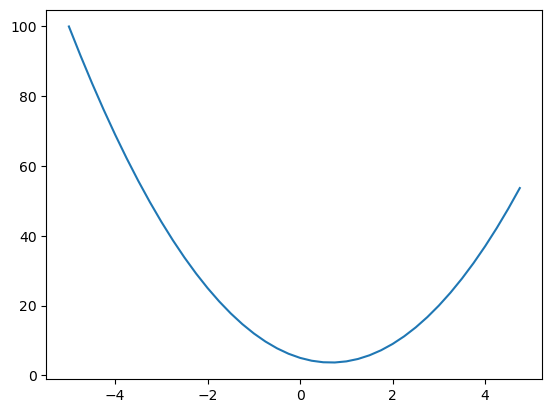

In [10]:
xs = np.arange(-5, 5, 0.25)
ys= f(xs)
plt.plot(xs, ys)

In [18]:
# What is the derivative at different points x of this function?
# Definition of the derivative - The derivative tells us how the functions responds by changing the input 
# slightly given an input x

h = 0.001
x = 3.0  # Also do again for -3
f(x), f(x+h)  # Will f(x+h) > f(x) or f(x+h) < f(x)?

(20.0, 20.014003000000002)

In [19]:
(f(x+h) -f(x)) / h  # Equation for derivative

14.00300000000243

In [20]:
# Now lets increase complexity

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


In [23]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a += h
# b += h
c += h
d2 = a*b + c

print(f'd1: {d1}, d1: {d2}, slope: {(d2-d1)/h}')  # Before running this think about how the "+= h" will affect the output


d1: 4.0, d1: 4.0001, slope: 0.9999999999976694


When working on our autograd (automatic gradient, i.e. using backpropagation) engine we first must create an object which can store each Value in our expressions.

I provide the implementation of the "Value" class below. This class has 5 attributes and will store the information necessary to compute the gradients in our expressrions.

In [5]:
class Value:
            
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data            # The actual data of the Value object
        self.grad = 0.0             # Keep track of the grad w.r.t any input node
        self._prev = set(_children) # The children of the node, i.e what inputs created this current Value
        self._op = _op              # The operation used to create this node
        self.label = label          # The "name" of this Value
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [53]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [54]:
d._op

'+'

In [6]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

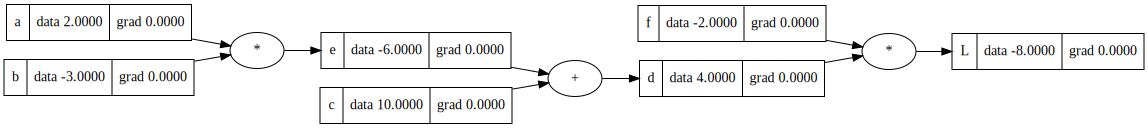

In [39]:
draw_dot(L)

In [70]:
# So we have can build out scalar valued mathematical expressions and do a forward pass to build 
# a complete mathematical expression with multiple inputs

# Now lets do backprop on this expression!!!

In [75]:
# Manually set the gradients here
# e.g.
L.grad = 1

f.grad = ...
d.grad = ...

e.grad = ...
c.grad = ...

a.grad = ...
b.grad = ...

In [100]:
# estimating gradients as before! Use this code to verify your manual derivations.

def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

0.0


Lets derive the derivatives of the output L w.r.t to each input in the expression by hand first.

We have three equations: 
    $$e = a * b$$
    $$d = e + c$$
    $$L = d * f$$

And we can use the chain rule to get the derivatives of L w.r.t to each: L, d, f, e, c, a, b

<b> Chain rule: </b>
    $$\frac{dy}{dx}=\frac{dy}{du} \frac{du}{dx}$$

In [98]:
# All that should give us the following gradients
L.grad = 1

f.grad = 4.0
d.grad = -2.0

e.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

In [92]:
# Now we can use the gradient information we calculated and stored in our Value objects to do a forward pass
# which should minimise L slightly!
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# You may notice we don't actually use the gradients of e and d, why is that?

# It's becuase they are intermediate variables who's value is determined by a,c,b and f. They have no independent
# existence outside of these variables.

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


## An example of manual back propagation!

This is an example thought up by yours truly so it may not work as expected but lets give it a go!

I am going to give you some mathematical expressions and they will be chained together to form a simple neural network. We will use backpropagation to figure out the approx values of the parameters of the pseduo-network and get to the base function!

We will initialise the values of the function to some randon number and we want to bump them using backpropagation and gradient descent to figure out the hidden function!

Our input is 5 and the target output is -160

In [457]:
def MSE(y, yhat):
    if isinstance(y, list):
        n = len(y)
        errors = sum(y - yhat)
        MSE = (1/n) * (errors**2)
        
        return MSE
    
    else:
        MSE = (y - yhat)**2
    
        return MSE

In [539]:
y = -160

In [540]:
x = Value(5, label='x')

n = Value(np.random.randint(-10, -2), label='n')
f1 = n * x; f1.label = 'f1'

m = Value(np.random.randint(13, 17), label='m')
f2 = m + f1; f2.label = 'f2'

o = Value(np.random.randint(2, 6), label='o')
yhat = o * f2; yhat.label = 'yhat'

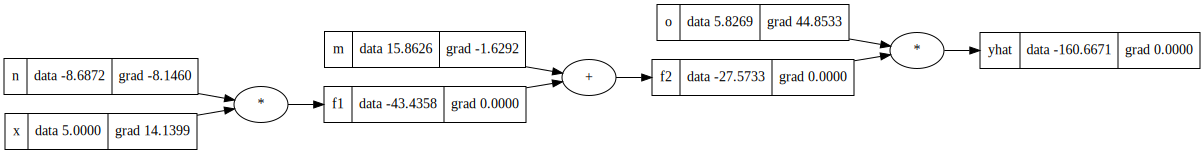

In [587]:
draw_dot(yhat)

In [542]:
yhat, MSE(y, yhat.data)

(Value(data=-72), 7744)

# Lets compute gradient with just respect to the output and see what happens!

In [305]:
x.grad = o.data * n.data
n.grad = o.data * x.data

f1.grad = o.data
m.grad = o.data

f2.grad = o.data
o.grad = f2.data

yhat.grad = 1

In [306]:
n.data += 0.001 * n.grad
m.data += 0.001 * m.grad
o.data += 0.001 * o.grad


f1 = n * x; f1.label = 'f1'
f2 = m + f1; f2.label = 'f2'
yhat = o * f2; yhat.label = 'yhat'

In [307]:
yhat, MSE(y, yhat.data)

(Value(data=396.95913512339996), 299164.2954949377)

# Now lets compute the gradients w.r.t to L (MSE)

In [585]:
yhat.grad = 2*(y - yhat.data)

o.grad = yhat.grad * f2.data
f2.grad = yhat.grad * o.data

m.grad = yhat.grad
f1.grad = yhat.grad

n.grad = yhat.grad * x.data
x.grad = yhat.grad * n.data

In [586]:
n.data += 0.001 * n.grad
m.data += 0.001 * m.grad
o.data += 0.001 * o.grad


f1 = n * x; f1.label = 'f1'
f2 = m + f1; f2.label = 'f2'
yhat = o * f2; yhat.label = 'yhat'

yhat, MSE(y, yhat.data)

(Value(data=-160.66707620577674), 0.44499066431348844)

## Below is a simple neural network which does the same thing!!!

In [142]:
import torch
import torch.nn as nn
import numpy as np

class SimpleFFNet(nn.Module):
    def __init__(self):
        super(SimpleFFNet, self).__init__()
        self.layer1 = nn.Linear(1, 1, bias=False)
        self.layer2 = nn.Linear(1, 1, bias=True)
        self.layer3 = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleFFNet()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Example input and target output
x = torch.tensor([[5.]], requires_grad=True)  # Your input
target = torch.tensor([[-160.]])  # Assuming you want the model to learn to output 10 for input 10

# Training loop
for epoch in range(50):  
    optimizer.zero_grad()  
    output = model(x)  
    print(output)
    loss = criterion(output, target)  
    loss.backward()  
    optimizer.step()  

    if epoch % 5 == 0:  
        print(f'Epoch {epoch}, Loss: {loss.item()}')


tensor([[-0.0233]], grad_fn=<MmBackward0>)
Epoch 0, Loss: 22492.99609375
tensor([[-0.0308]], grad_fn=<MmBackward0>)
tensor([[-0.0395]], grad_fn=<MmBackward0>)
tensor([[-0.0498]], grad_fn=<MmBackward0>)
tensor([[-0.0621]], grad_fn=<MmBackward0>)
tensor([[-0.0770]], grad_fn=<MmBackward0>)
Epoch 5, Loss: 22476.912109375
tensor([[-0.0951]], grad_fn=<MmBackward0>)
tensor([[-0.1174]], grad_fn=<MmBackward0>)
tensor([[-0.1448]], grad_fn=<MmBackward0>)
tensor([[-0.1789]], grad_fn=<MmBackward0>)
tensor([[-0.2215]], grad_fn=<MmBackward0>)
Epoch 10, Loss: 22433.609375
tensor([[-0.2750]], grad_fn=<MmBackward0>)
tensor([[-0.3428]], grad_fn=<MmBackward0>)
tensor([[-0.4296]], grad_fn=<MmBackward0>)
tensor([[-0.5417]], grad_fn=<MmBackward0>)
tensor([[-0.6887]], grad_fn=<MmBackward0>)
Epoch 15, Loss: 22293.8671875
tensor([[-0.8842]], grad_fn=<MmBackward0>)
tensor([[-1.1489]], grad_fn=<MmBackward0>)
tensor([[-1.5152]], grad_fn=<MmBackward0>)
tensor([[-2.0349]], grad_fn=<MmBackward0>)
tensor([[-2.7943]], 

In [143]:
model.layer1.weight, model.layer1.bias

(Parameter containing:
 tensor([[3.0623]], requires_grad=True),
 None)

In [144]:
model.layer2.weight, model.layer2.bias

(Parameter containing:
 tensor([[-3.1154]], requires_grad=True),
 Parameter containing:
 tensor([-0.5441], requires_grad=True))

In [145]:
model.layer3.weight, model.layer3.bias

(Parameter containing:
 tensor([[3.1091]], requires_grad=True),
 None)